# Прогнозированию оттока клиентов для оператора связи «ТелеДом»

### Описание услуг

Оператор предоставляет два основных типа услуг:

- Стационарную телефонную связь. Телефон можно подключить к нескольким линиям одновременно.
- Интернет. Подключение может быть двух типов: через телефонную линию (`DSL`, от англ. digital subscriber line — «цифровая абонентская линия») или оптоволоконный кабель (`Fiber optic`).

Также доступны такие услуги:

- Интернет-безопасность: антивирус (`DeviceProtection`) и блокировка небезопасных сайтов (`OnlineSecurity`);
- Выделенная линия технической поддержки (`TechSupport`);
- Облачное хранилище файлов для резервного копирования данных (`OnlineBackup`);
- Стриминговое телевидение (`StreamingTV`) и каталог фильмов (`StreamingMovies`).

Клиенты могут платить за услуги каждый месяц или заключить договор на 1–2 года. Возможно оплатить счёт разными способами, а также получить электронный чек.

### Описание данных

Данные состоят из нескольких файлов, полученных из разных источников:

- `contract_new.csv` — информация о договоре;
- `personal_new.csv` — персональные данные клиента;
- `internet_new.csv` — информация об интернет-услугах;
- `phone_new.csv` — информация об услугах телефонии.

**Файл `contract_new.csv`**

- `customerID` — идентификатор абонента;
- `BeginDate` — дата начала действия договора;
- `EndDate` — дата окончания действия договора;
- `Type` — тип оплаты: раз в год-два или ежемесячно;
- `PaperlessBilling` — электронный расчётный лист;
- `PaymentMethod` — тип платежа;
- `MonthlyCharges` — расходы за месяц;
- `TotalCharges` — общие расходы абонента.

**Файл `personal_new.csv`**

- `customerID` — идентификатор пользователя;
- `gender` — пол;
- `SeniorCitizen` — является ли абонент пенсионером;
- `Partner` — есть ли у абонента супруг или супруга;
- `Dependents` — есть ли у абонента дети.

**Файл `internet_new.csv`**

- `customerID` — идентификатор пользователя;
- `InternetService` — тип подключения;
- `OnlineSecurity` — блокировка опасных сайтов;
- `OnlineBackup` — облачное хранилище файлов для резервного копирования данных;
- `DeviceProtection` — антивирус;
- `TechSupport` — выделенная линия технической поддержки;
- `StreamingTV` — стриминговое телевидение;
- `StreamingMovies` — каталог фильмов.

**Файл `phone_new.csv`**

- `customerID` — идентификатор пользователя;
- `MultipleLines` — подключение телефона к нескольким линиям одновременно.

Во всех файлах столбец `customerID` содержит код клиента. Информация о договорах актуальна на 1 февраля 2020 года.


**Оглавление проекта**
* [Проект Телекоммуникации](#Проект-телекоммуникации)
    * [Описание услуг](#Описание-услуг)
    * [Описание данных](#Описание-данных)
    * [Загрузка данных](#Шаг-1.-Загрузка-данных)
        * [Анализ contract_new](#contract_new-датафрейм)
        * [Анализ internet_new](#internet_new-датафрейм)
        * [Анализ personal_new](#personal_new-датафрейм)
        * [Анализ phone_new](#phone_new-датафрейм)
    * [Объединение данных](#Шаг-3.-Объединение-данных)
    * [Исследовательский анализ и предобработка данных объединённого датафрейма](#Шаг-4.-Исследовательский-анализ-и-предобработка-данных-объединённого-датафрейма)
        * [Построение матрицы корреляции](#Построение-матрицы-корреляции)
        * [Графики распределений](#Графики-распределений)
        * [Анализ категориальных признаков в зависимости от того, ушел пользователь или нет](#Анализ-категориальных-признаков-в-зависимости-от-того,-ушел-пользователь-или-нет)
        * [Анализ количественных признаков в зависимости от того, ушел пользователь или нет](#Анализ-количественных-признаков-в-зависимости-от-того,-ушел-пользователь-или-нет)
    * [Подготовка данных](#Шаг-5.-Подготовка-данных)
    * [Обучение моделей машинного обучения](#Шаг-6.-Обучение-моделей-машинного-обучения)
    * [Выбор лучшей модели](#Шаг-7.-Выбор-лучшей-модели)
    * [Шаг 8. Общий вывод и рекомендации заказчику](#Шаг-8.-Общий-вывод-и-рекомендации-заказчику)
        * [Общий вывод по проекту](#Общий-вывод-по-проекту:)

Импортируем все необходимые библиотеки и объявим глобальные переменные

In [1]:
import sys
!pip install phik -q
!pip install shap -q
!pip install numba -q
!pip install LightGBM -q

In [2]:
!pip install --upgrade scikit-learn==1.3.2 -q
!pip install --upgrade seaborn==0.13.0 -q
!pip install --upgrade shap==0.45.0 -q
!pip install --upgrade phik==0.12.4 -q
!pip install --upgrade pandas==2.1.4 -q
!pip install --upgrade scipy==1.12.0 -q
!pip install --upgrade matplotlib==3.8.0 -q
!pip install --upgrade numba -q

In [3]:
import gc
import os
import re
from math import log

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
import phik
import shap
shap.initjs()

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve

from lightgbm import LGBMClassifier

In [4]:
sns.set_theme()
sns.set_palette('Set2')
RANDOM_STATE = 20924
TEST_SIZE = 0.25

## Шаг 1. Загрузка данных

In [5]:
def read_files(path, numerical_data='.', time_data = None):
    if (os.path.exists(path)):
        data = pd.read_csv(path, decimal=numerical_data, parse_dates=time_data)
        print(f'Success, files was read with path {path}')
        return data

    elif (os.path.exists('.' + path)):
        data = pd.read_csv(path, decimal=numerical_data, parse_dates=time_data)
        print(f'Success, local files was read with path {"." + path}')
        return data

    else:
        print('something went wrong')

In [6]:
contract_new = read_files('/datasets/contract_new.csv', numerical_data='.', time_data=['BeginDate'])
internet_new = read_files('/datasets/internet_new.csv')
personal_new = read_files('/datasets/personal_new.csv')
phone_new = read_files('/datasets/phone_new.csv')

Success, files was read with path /datasets/contract_new.csv
Success, files was read with path /datasets/internet_new.csv
Success, files was read with path /datasets/personal_new.csv
Success, files was read with path /datasets/phone_new.csv


Проверим, что данные верно считаны и готовы к дальнейшему анализу

In [7]:
contract_new.sample(5, random_state=RANDOM_STATE)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
308,3167-SNQPL,2016-12-01,No,Month-to-month,No,Electronic check,101.15,3882.14
169,1159-WFSGR,2018-10-01,No,Month-to-month,No,Electronic check,20.40,326.4
2305,4947-DSMXK,2017-04-01,No,Month-to-month,Yes,Bank transfer (automatic),97.70,3321.8
2229,3496-LFSZU,2019-10-01,No,Month-to-month,No,Electronic check,70.50,290.46
6827,1036-GUDCL,2015-02-01,No,Month-to-month,Yes,Credit card (automatic),79.05,5217.3


In [8]:
internet_new.sample(5, random_state=RANDOM_STATE)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
2749,7587-RZNME,DSL,No,No,No,No,No,No
1077,9415-DPEWS,Fiber optic,No,No,No,Yes,Yes,No
3258,4223-WOZCM,DSL,No,No,Yes,No,No,No
3354,2114-MGINA,Fiber optic,No,No,No,No,Yes,Yes
989,5565-FILXA,Fiber optic,No,No,No,No,Yes,Yes


In [9]:
personal_new.sample(5, random_state=RANDOM_STATE)

,customerID,gender,SeniorCitizen,Partner,Dependents
308,3167-SNQPL,Male,1,Yes,Yes
169,1159-WFSGR,Female,0,Yes,Yes
2305,4947-DSMXK,Male,0,Yes,Yes
2229,3496-LFSZU,Male,0,Yes,No
6827,1036-GUDCL,Male,0,Yes,Yes


In [10]:
phone_new.sample(5, random_state=RANDOM_STATE)

,customerID,MultipleLines
4718,6050-IJRHS,Yes
755,2672-TGEFF,Yes
162,3712-PKXZA,No
993,8659-IOOPU,Yes
1366,5724-BIDBU,Yes


Данные верно считаны и представлены в виде 4 датафреймов. Нет необходимости переименовывать названия столбцов, поскольку они названы корректно, во время предобработки данных проведем приведение к нижнему регистру, для удобства.

Продолжим первичный осмотр данных: посмотрим, какие типы данных представленны, а также узнаем количество пропусков

In [11]:
def get_info(data: pd.DataFrame) -> None:
    '''
    Function for printing base information of dataframe
    :param data: dataframe for search
    '''
    print('Info about data:')
    data.info()
    print('\nInfo about missing data:\n', data.isna().sum())

In [12]:
print('Info about contract_new dataframe')
get_info(contract_new)

Info about contract_new dataframe
Info about data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(6)
memory usage: 440.3+ KB

Info about missing data:
 customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64


Обратим внимание, что `TotalCharges` представлено в виде объекта, а не числа. Этот момент необходимо обработать на этапе предобработки данных. Для столбца `EndDate` из-за того, что есть данные, не соответствующие типу datetime будет проведена конвертация на следующем этапе

In [13]:
print('Info about internet_new dataframe')
get_info(internet_new)

Info about internet_new dataframe
Info about data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB

Info about missing data:
 customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64


In [14]:
print('Info about personal_new dataframe')
get_info(personal_new)

Info about personal_new dataframe
Info about data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB

Info about missing data:
 customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64


In [15]:
print('Info about phone_new dataframe')
get_info(phone_new)

Info about phone_new dataframe
Info about data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB

Info about missing data:
 customerID       0
MultipleLines    0
dtype: int64


Стоит отметить отсутствие пропусков во всех датафреймах

Однако количество данных колеблется от датафрейма к датафрейму

**Вывод:**
- Данные были успешно прочитаны и преобразованы в датафрейм
- Датафреймы представляют собой данные о пользователях, предоставляемых им услугах, оплаты тарифов
- Представлены датафреймы разной длины - 7043, 6361 и 5517 строк. В каждом датафрейме определенное количество признаков, которые необходимо привести к нижнему регистру для удобства работы.

## **Шаг 2. Исследовательский анализ и предобработка данных**

Проведем исследовательский анализ данных и предобработку перед этим. Для этого приведем к нижнему регистру названия столбцов, а далее рассмотрим наличие дубликатов и различных выбросов

In [16]:
def dict_columns(names):
    res = {}
    for name in names:
        modified_name = re.sub(r'(?<!^)(?<![A-Z])(?=[A-Z])', '_', name)
        res[name] = modified_name.lower()
    
    return res

In [17]:
for df in (contract_new, internet_new, personal_new, phone_new):
    df.rename(columns=dict_columns(df.columns), inplace=True)


Проверим, что все успешно переименовалось

In [18]:
contract_new.sample(1, random_state=RANDOM_STATE)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
308,3167-SNQPL,2016-12-01,No,Month-to-month,No,Electronic check,101.15,3882.14


Проведем теперь анализ данных для предобработки

In [19]:
def get_unique_values_with_counts(data: pd.DataFrame, col: list) -> str:
    """
    get values and their names into one str line
    params: data: dataframe for research
            col: column from dataframe for research
    return: str line with names and values
    """
    unique_values = data[col].unique()
    value_counts = data[col].value_counts()
    result = [f'{value} ({count})' for value, count in zip(unique_values, value_counts)]
    return ', '.join(result)


def unique_data(data: pd.DataFrame) -> None:
    """
    Output of unique data if it's count less tan ten
    params: data: dataframe for research
    """
    for col in data:
        if len(data[col].unique()) < 40:
            print(f'{col}: {get_unique_values_with_counts(data, col)}')

In [20]:
def numerical_plot(df: pd.DataFrame, title: str, features: dict):
    '''
    function for plotting numerical distribution
    params: df: dataframe for research
            tltle: name for plot title
            features: dict of features to research, keys - eng, values - ru for captions
    '''
    print(f'Графики количественных признаков для {title}')
    for feature, feat_ru in features.items():
        fig, axes = plt.subplots(1, 2, figsize=(18, 5))
        if df[feature].dtype == 'int64' and len(df[feature].unique()) < 20:
            sns.countplot(data=df, x=feature, ax=axes[0])
        else:
            sns.histplot(data=df, x=feature, kde=True, ax=axes[0],
                         bins=round(log((len(df[feature].unique()) + 1)) * 2, ))
        sns.boxplot(data=df, x=feature, ax=axes[1])
        fig.suptitle(f'Распределение для {feat_ru}')
        for num in range(2):
            axes[num].set_ylabel('Количество')
            axes[num].set_xlabel(feat_ru)

In [21]:
def categorial_plot(df: pd.DataFrame, title: str, features: dict) -> None:
    '''
    Function for plotting categorial distribution
    params: df: dataframe for research
            tltle: name for plot title
            features: dict of features to research, keys - eng, values - ru for captions
    '''
    print(f'Графики категориальных признаков для {title}')

    for feature, feat_ru in features.items():
        data = df[feature].value_counts().to_frame().reset_index()
        if len(data['count'].unique()) > 1:
            fig, axes = plt.subplots(1, 2, figsize=(20, 4))
            fig.suptitle(f'Распределение для {feat_ru}')
            axes[0].yaxis.grid(True)
            sns.barplot(data=data, y=feature, x='count', ax=axes[0])
            axes[0].set_xlabel('Количество', fontsize=12)
            axes[0].set_ylabel(feat_ru, fontsize=12)
            axes[1].pie(data['count'], labels=data[feature], autopct='%.1f%%', radius=1)
        else:
            print(
                f'Для категориального признака "{feat_ru}" одинаковое количество данных на все группы: {data["count"][0]}')

### contract_new датафрейм

In [22]:
unique_data(contract_new)

type: Month-to-month (3875), One year (1695), Two year (1473)
paperless_billing: Yes (4171), No (2872)
payment_method: Electronic check (2365), Mailed check (1612), Bank transfer (automatic) (1544), Credit card (automatic) (1522)


In [23]:
contract_new['end_date'].unique()

array(['No', '2017-05-01', '2016-03-01', '2018-09-01', '2018-11-01',
       '2018-12-01', '2019-08-01', '2018-07-01', '2017-09-01',
       '2015-09-01', '2016-07-01', '2016-06-01', '2018-03-01',
       '2019-02-01', '2018-06-01', '2019-06-01', '2020-01-01',
       '2019-11-01', '2016-09-01', '2015-06-01', '2016-12-01',
       '2019-05-01', '2019-04-01', '2017-06-01', '2017-08-01',
       '2018-04-01', '2018-08-01', '2018-02-01', '2019-07-01',
       '2015-12-01', '2014-06-01', '2018-10-01', '2019-01-01',
       '2017-07-01', '2017-12-01', '2018-05-01', '2015-11-01',
       '2019-10-01', '2019-03-01', '2016-02-01', '2016-10-01',
       '2018-01-01', '2017-11-01', '2015-10-01', '2019-12-01',
       '2015-07-01', '2017-04-01', '2015-02-01', '2017-03-01',
       '2016-05-01', '2016-11-01', '2015-08-01', '2019-09-01',
       '2017-10-01', '2017-02-01', '2016-08-01', '2016-04-01',
       '2015-05-01', '2014-09-01', '2014-10-01', '2017-01-01',
       '2015-03-01', '2015-01-01', '2016-01-01', 

In [24]:
contract_new.loc[contract_new['end_date'] != 'No', 'end_date'] = pd.to_datetime(
    contract_new.loc[contract_new['end_date'] != 'No', 'end_date'])

Провели преобразование для даты

In [25]:
def is_number(s):
    try:
        float(s.replace('.', '', 1))
        return True
    except ValueError:
        return False
    
mask = contract_new['total_charges'].apply(is_number)

contract_new[~mask]['total_charges'].unique()

array([' '], dtype=object)

Соответственно из-за наличия ' ' у нас не произошла сразу конвертация в число с плавающей точкой. Сделаем это вручную

In [26]:
contract_new['total_charges'] = contract_new['total_charges'].replace([' ', ''], pd.NA)

contract_new = contract_new.dropna(subset=['total_charges'])

In [27]:
contract_new['total_charges'] = pd.to_numeric(contract_new['total_charges'], errors='coerce')

In [28]:
contract_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7032 non-null   object        
 1   begin_date         7032 non-null   datetime64[ns]
 2   end_date           7032 non-null   object        
 3   type               7032 non-null   object        
 4   paperless_billing  7032 non-null   object        
 5   payment_method     7032 non-null   object        
 6   monthly_charges    7032 non-null   float64       
 7   total_charges      7032 non-null   float64       
dtypes: datetime64[ns](1), float64(2), object(5)
memory usage: 494.4+ KB


In [29]:
contract_new.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.60
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.50


Рассмотрим теперь какие данные присутствуют в датафрейме

In [30]:
categorial_features_contract = {'type': 'тип_оплаты',
                                'paperless_billing': 'электронный_расчётный_лист',
                                'payment_method': 'загруженность', }

numerical_features_contract = {'monthly_charges': 'расходы_за_месяц',
                               'total_charges': 'общие_расходы_абонента', }

Графики количественных признаков для Графики количественных признаков для датафрейма с информацией о договоре


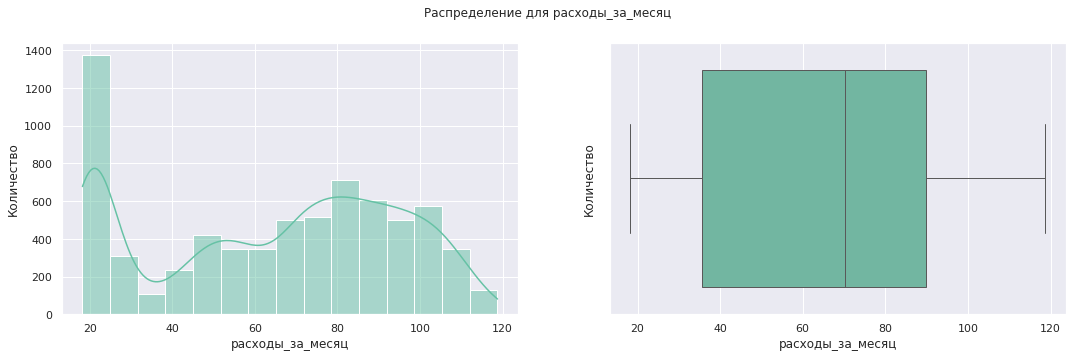

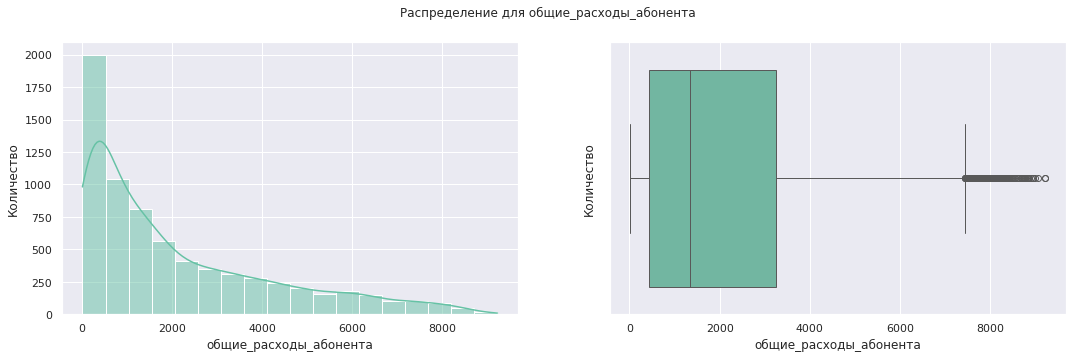

In [31]:
numerical_plot(contract_new, 'Графики количественных признаков для датафрейма с информацией о договоре', 
               numerical_features_contract)

Можно выделить большой выброс данных в районе 20 для расходов абонента за месяц. Аналогичная ситуация наблюдается для общих расходов абонента - очень много пользователей с низкими расходами. Рассмотрим детально, какое минимальное и медианное значение для этих двух признаков

In [32]:
contract_new[numerical_features_contract.keys()].describe()

,monthly_charges,total_charges
count,7032.000000,7032.000000
mean,64.798208,2118.621822
std,30.085974,2112.736199
min,18.250000,19.050000
25%,35.587500,439.745000
50%,70.350000,1345.275000
75%,89.862500,3239.317500
max,118.750000,9221.380000


Поскольку минимальные значения это не нули, вероятно это какая-то дешевая подписка у большого количества пользователей. За счет достаточного количества пользователей с подпиской более 60, медианное значение для месячных трат - 70. Не смотря на то, что у общих расходов абонента пик приходится ближе к нулю, медианой является 1345.

Графики категориальных признаков для Графики категориальных признаков для датафрейма с информацией о договоре


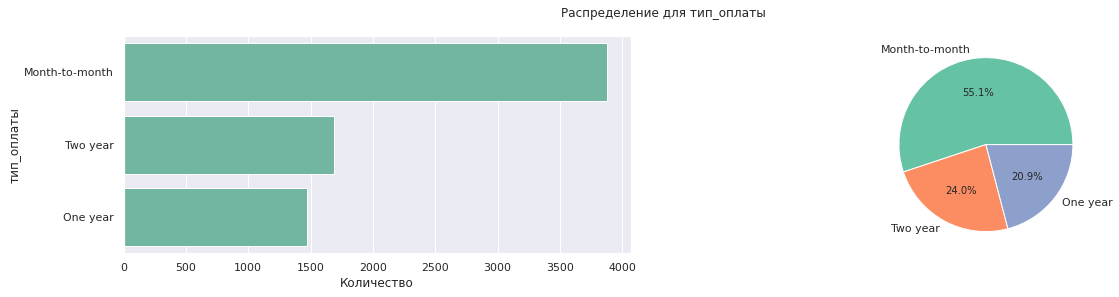

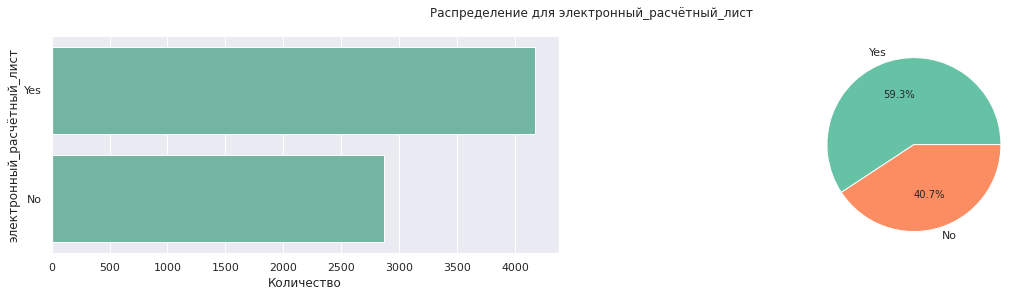

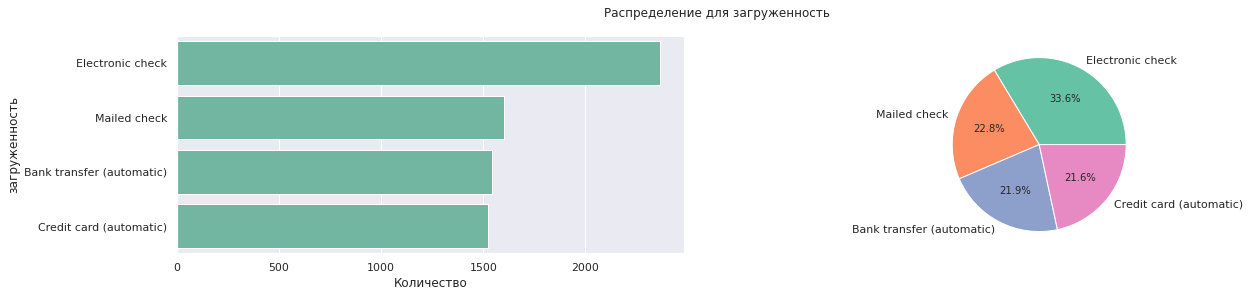

In [33]:
categorial_plot(contract_new, 'Графики категориальных признаков для датафрейма с информацией о договоре', 
                categorial_features_contract)

In [34]:
contract_new[categorial_features_contract.keys()].describe(include='all')

,type,paperless_billing,payment_method
count,7032,7032,7032
unique,3,2,4
top,Month-to-month,Yes,Electronic check
freq,3875,4168,2365


Сформируем таргет и преобразуем даты начала и конца в один признак - длительность

In [35]:
contract_new['target'] = contract_new['end_date'].apply(lambda x: 'Yes' if x != 'No' else 'No')

contract_new['end_date'] = contract_new['end_date'].replace({'No': '2020-02-01'})
contract_new['end_date'] = pd.to_datetime(contract_new['end_date'])
contract_new['duration'] = (contract_new['end_date'] - contract_new['begin_date']).dt.days
contract_new = contract_new.drop(columns=['end_date', 'begin_date'])

**Вывод по датафрейму contract_new**:
- принаков в датафрейме - 8, один из которых идентификатор пользователя. Дата конца контракта была преобразована в таргетную переменную, а разница между началом и концом контракта была преобразована в новый признак - длительность.
- количественных признаков изначально 2: `monthly_charges`, `total_charges`, для последнего было удалено малое количество пропусков, которые мешали преобразованию столбца. Также в количественный признак можно включить новый созданный признак - длительность контракта
- Категориальных признаков в датафрейме 3: `type`, `paperless_billing`, `payment_method`. `paper_billing` является бинарным признаком

### internet_new датафрейм

In [36]:
unique_data(internet_new)

internet_service: DSL (3096), Fiber optic (2421)
online_security: No (3498), Yes (2019)
online_backup: Yes (3088), No (2429)
device_protection: No (3095), Yes (2422)
tech_support: No (3473), Yes (2044)
streaming_tv: No (2810), Yes (2707)
streaming_movies: No (2785), Yes (2732)


In [37]:
internet_new.describe(include='all')

,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,3186-AJIEK,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


In [38]:
internet_new.shape

(5517, 8)

Дополнительной обработки данных для этого датафрейма не нужно делать

**Вывод по датафрейму internet_new**:
- В датафрейме 8 признаков, один из которых - уникальный идентификатор пользователя
- Остальные признаки - категориальные бинарные признаки
- Данный датафрейм - самый маленький по количеству строк - 5517

### personal_new датафрейм

In [39]:
unique_data(personal_new)

gender: Female (3555), Male (3488)
senior_citizen: 0 (5901), 1 (1142)
partner: Yes (3641), No (3402)
dependents: No (4933), Yes (2110)


Преобразуем бинарный признак `senior_citizen` в категориальный для удобства работы.

In [40]:
personal_new['senior_citizen'] = personal_new['senior_citizen'].replace({0: 'No', 1: 'Yes'})

In [41]:
personal_new.describe(include='all')

,customer_id,gender,senior_citizen,partner,dependents
count,7043,7043,7043,7043,7043
unique,7043,2,2,2,2
top,3186-AJIEK,Male,No,No,No
freq,1,3555,5901,3641,4933


In [42]:
personal_new.shape

(7043, 5)

**Вывод по датафрейму personal_new**:
- В датафрейме 5 признаков, один из которых - уникальный идентификатор пользователя
- Остальные признаки - категориальные бинарные признаки, для признака `senior_citizen` было выполнено преобразование из {0, 1} в {'Yes', 'No'}
- Количество строк в данном датафрейме - 7043

### phone_new датафрейм

In [43]:
unique_data(phone_new)

multiple_lines: No (3390), Yes (2971)


In [44]:
phone_new.describe(include='all')

,customer_id,multiple_lines
count,6361,6361
unique,6361,2
top,3186-AJIEK,No
freq,1,3390


In [45]:
phone_new.shape

(6361, 2)

**Вывод по датафрейму phone_new**:
- В датафрейме 2 признака, один из которых - уникальный идентификатор пользователя
- Второй признак - категориальный бинарный признак наличия подключения к нескольким линиям одновременно
- Количество строк в данном датафрейме - 6361

**Финальный вывод по блоку исследовательского анализа и предобработки каждого датафрейма в отдельности**:

**contract_new**
- Признаки:
  - В датафрейме 8 признаков, один из которых — уникальный идентификатор пользователя.
  - Дата конца контракта была преобразована в таргетную переменную, а разница между началом и концом контракта была преобразована в новый признак — длительность.

- Количественные признаки:
  - Изначально было 2 количественных признака: monthly_charges и total_charges.
  - Для признака total_charges было удалено малое количество пропусков, мешавших преобразованию столбца.
  - Новый созданный признак — длительность контракта — также можно включить в количественные признаки.
      
- Графическое представление monthly_charges и total_charges:
  - Расходы за месяц (monthly_charges):
    - Гистограмма показывает, что большинство значений находятся в диапазоне от 20 до 40, но значительное количество значений также расположено в диапазоне от 80 до 120.
    - Boxplot показывает распределение значений, медиану, квартали и предполагает наличие выбросов.
  - Общие расходы абонента (total_charges):
    - Гистограмма показывает асимметрическое распределение с большим количеством значений в низком диапазоне.
    - Boxplot подтверждает наличие выбросов на верхнем уровне.

- Категориальные признаки:
  - В датафрейме 3 категориальных признака: type, paperless_billing, payment_method.
  - paperless_billing является бинарным признаком.

**internet_new**

- В датафрейме 8 признаков, один из которых — уникальный идентификатор пользователя.
- Остальные признаки — категориальные бинарные признаки.
- Наименьший по количеству строк — 5517 строк.

**personal_new**
- В датафрейме 5 признаков, один из которых — уникальный идентификатор пользователя.
- Остальные признаки — категориальные бинарные признаки.
- Для признака senior_citizen было выполнено преобразование значений из {0, 1} в {'Yes', 'No'}.
- Количество строк — 7043.

**phone_new**
- В датафрейме 2 признака, один из которых — уникальный идентификатор пользователя.
- Второй признак — категориальный бинарный признак наличия подключения к нескольким линиям одновременно.
- Количество строк — 6361.

Датафрейм contract_new содержит важные количественные и категориальные признаки, которые могут предоставить ценные инсайты для анализа. Анализ распределений признаков monthly_charges и total_charges показал разнообразие значений, а также наличие выбросов, что может быть полезным для дальнейшего статистического и машинного анализа данных. Остальные таблицы (internet_new, personal_new, phone_new) состоят в основном из бинарных категориальных признаков и отличаются лишь количеством строк.

## **Шаг 3. Объединение данных**

In [46]:
df = (contract_new
        .merge(personal_new, how='left', on='customer_id')
        .merge(internet_new, how='left', on='customer_id')
        .merge(phone_new, how='left', on='customer_id'))
df.set_index('customer_id', inplace=True)

In [47]:
df.fillna('No_info', inplace=True)

In [48]:
df.head()

,type,paperless_billing,payment_method,monthly_charges,total_charges,target,duration,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
customer_id,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,31.04,No,31,Female,No,Yes,No,DSL,No,Yes,No,No,No,No,No_info
5575-GNVDE,One year,No,Mailed check,56.95,2071.84,No,1036,Male,No,No,No,DSL,Yes,No,Yes,No,No,No,No
3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,226.17,No,123,Male,No,No,No,DSL,Yes,Yes,No,No,No,No,No
7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1960.60,No,1371,Male,No,No,No,DSL,Yes,No,Yes,Yes,No,No,No_info
9237-HQITU,Month-to-month,Yes,Electronic check,70.70,353.50,No,153,Female,No,No,No,Fiber optic,No,No,No,No,No,No,No


In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   type               7032 non-null   object 
 1   paperless_billing  7032 non-null   object 
 2   payment_method     7032 non-null   object 
 3   monthly_charges    7032 non-null   float64
 4   total_charges      7032 non-null   float64
 5   target             7032 non-null   object 
 6   duration           7032 non-null   int64  
 7   gender             7032 non-null   object 
 8   senior_citizen     7032 non-null   object 
 9   partner            7032 non-null   object 
 10  dependents         7032 non-null   object 
 11  internet_service   7032 non-null   object 
 12  online_security    7032 non-null   object 
 13  online_backup      7032 non-null   object 
 14  device_protection  7032 non-null   object 
 15  tech_support       7032 non-null   object 
 16  streaming_tv  

**Вывод**:
- Все 4 датафрейма были объединены между собой по идентификатору пользователя.
- Поскольку данные были объедены относительно `contract_new` (информация о договоре), были заполнены пропуски при помощи заглушки

## **Шаг 4. Исследовательский анализ и предобработка данных объединённого датафрейма**

### Построение матрицы корреляции

На этом этапе необходимо проанализировать корреляцию между признаками и таргетом. Будем использовать корреляцию по методу Спирмена

In [50]:
df.corr(method='spearman', numeric_only=True)

,monthly_charges,total_charges,duration
monthly_charges,1.000000,0.646433,0.252350
total_charges,0.646433,1.000000,0.876712
duration,0.252350,0.876712,1.000000


In [51]:
numeric_columns_сorr = ['monthly_charges',
                        'total_charges',
                        'duration']

In [52]:
def correlation_matrix(df: pd.DataFrame, columns: list, df_name: str) -> None:
    fig, axes = plt.subplots(2, 1, figsize=(12, 16))

    sns.heatmap(df.corr(method='spearman', numeric_only=True),
                annot=True,
                cmap='seismic',
                fmt=".2f",
                ax=axes[0])
    axes[0].set_title(f'Матрица корреляции количественных признаков для датафрейма {df_name} по методу Спирмена')

    ax = sns.heatmap(df.phik_matrix(interval_cols=numeric_columns_сorr),
                     cmap='seismic',
                     annot=True,
                     fmt=".1f",
                     linewidth=.5,
                     ax=axes[1])
    ax.set_title(f'Матрица кореляции для всех признаков датафрейма {df_name}')

    plt.tight_layout()

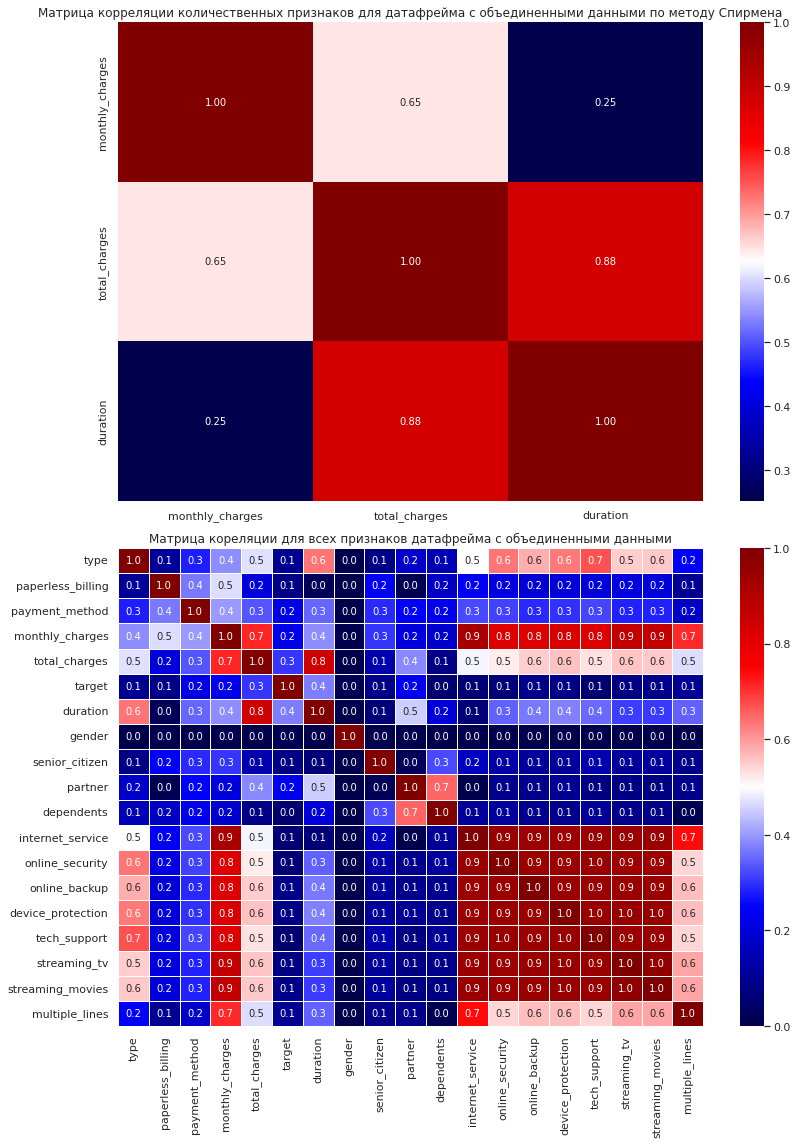

In [53]:
correlation_matrix(df, numeric_columns_сorr, 'с объединенными данными')

**Первая матрица: Корреляция Спирмена для количественных признаков**:
- total_charges и duration имеют очень высокую положительную корреляцию. Это логично, так как общие расходы суммируются с течением времени.
- monthly_charges и total_charges также имеют умеренную положительную корреляцию, что ожидаемо, так как более высокие месячные расходы увеличивают общие расходы.

**Вторая матрица: Корреляция с использованием phi-корреляции для всех признаков**:
- Целевая переменная (target):
    - payment_method: 0.2 – слабая положительная корреляция
    - monthly_charges: 0.2 – слабая положительная корреляция
    - total_charges: 0.3 – слабая положительная корреляция
    - duration: 0.4 – умеренная положительная корреляция
    - partner: 0.2 - слабая положительная корреляция

- monthly_charges:
     - total_charges, multiple_lines: 0.7 – высокая положительная корреляция
     - internet_service, streaming_tv, streaming_movies: 0.9 – высокая положительная корреляция
     - device_protection, tech_support, online_backup, online_security: 0.8 – высокая положительная корреляция
     - paperless_billing: 0.5 - умеренная положительная корреляция

- Уход клиента (target) имеет значимые корреляции с такими признаками, как duration (длительность контракта), monthly_charges, payment_method, partner и total_charges.

### Графики распределений

Для оценки зависимостей построим также графики зависимостей количественных переменных друг от друга

In [54]:
numerical_features_plot = {'monthly_charges': 'расходы за месяц',
                           'total_charges': 'общие расходы',
                           'duration': 'длительность контракта',
                           'target': ''}

In [55]:
def plot_correlation(df: pd.DataFrame, field: str = 'target',
                     signs: dict = numerical_features_plot) -> None:
    pair_plot = sns.pairplot(df[signs.keys()], hue=field)
    for ax in pair_plot.axes.flatten():
        xlabel = ax.get_xlabel()
        ylabel = ax.get_ylabel()
        
        if xlabel in signs:
            ax.set_xlabel(signs[xlabel])
        if ylabel in signs:
            ax.set_ylabel(signs[ylabel])

    legend = pair_plot._legend
    legend.set_title('Quit') 
    plt.setp(legend.get_texts(), fontsize='12')
    legend.set_bbox_to_anchor((1.1, 0.5))
    legend.set_frame_on(True)

    plt.tight_layout()

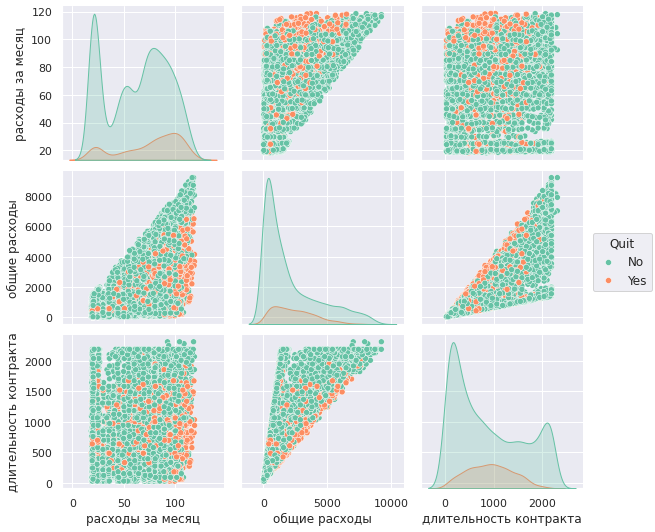

In [56]:
plot_correlation(df)

1. Расходы за месяц: Высокие расходы коррелируют с уходом.
2. Общие расходы: Клиенты с высокими общими расходами чаще покидают.
3. Длительность контракта: Клиенты с короткими контрактами и высокими расходами склонны к уходу.

### Анализ категориальных признаков в зависимости от того, ушел пользователь или нет

In [57]:
def categorial_plot_quit(df: pd.DataFrame, title: str, features: dict, sign: str or list = 'target') -> None:
    '''
    Function for plotting categorical distribution
    params: df: dataframe for research
            title: name for plot title
            features: dict of features to research, keys - eng, values - ru for captions
            sign: column indicating quitting status
    '''
    print(f'Графики категориальных признаков для {title}')

    for feature, feat_ru in features.items():
        data_no = df[df[sign] == "No"][feature].value_counts(normalize=True).reset_index()
        data_yes = df[df[sign] == "Yes"][feature].value_counts(normalize=True).reset_index()

        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        fig.suptitle(f'Распределение для {feat_ru}')

        axes[0].yaxis.grid(True)
        sns.barplot(data=data_no, hue=feature, y='proportion', ax=axes[0], palette='husl')
        axes[0].set_ylabel('Относительные частоты', fontsize=12)
        axes[0].legend(title=feat_ru, fontsize=12)
        axes[0].set_title('Для оставшихся клиентов')

        axes[1].yaxis.grid(True)
        sns.barplot(data=data_yes, hue=feature, y='proportion', ax=axes[1], palette='Set2')
        axes[1].set_ylabel('Относительные частоты', fontsize=12)
        axes[1].legend(title=feat_ru, fontsize=12)
        axes[1].set_title('Для ушедших клиентов')

        axes[2].pie(data_yes['proportion'], labels=data_yes[feature], autopct='%.1f%%', radius=1)
        axes[2].set_title('Распределение для ушедших клиентов')

        plt.tight_layout()

In [58]:
categories = {'type': 'тип оплаты',
               'paperless_billing': 'электронный расчётный лист',
               'payment_method': 'тип платежа',
               'gender': 'пол',
               'senior_citizen': 'абонент пенсионер',
               'partner': 'наличие супруга',
               'dependents': 'наличие детей',
               'internet_service': 'тип подключения',
               'online_security': 'блокировка опасных сайтов',
               'online_backup': 'облачное хранилище',
               'device_protection': 'антивирус',
               'tech_support': 'линия технической поддержки',
               'streaming_tv': 'стриминговое телевидение',
               'streaming_movies': 'каталог фильмов',
               'multiple_lines': 'подключение к нескольким линиям'}

Графики категориальных признаков для Составление портрета ушедшего клиента


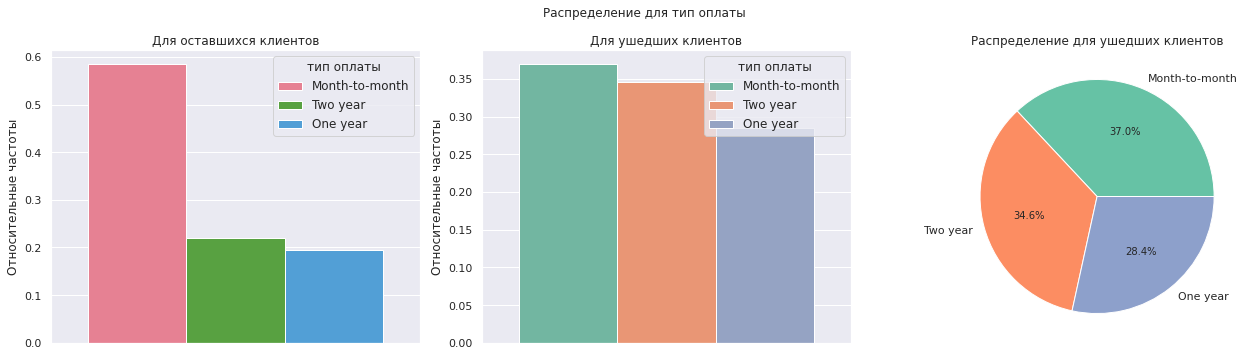

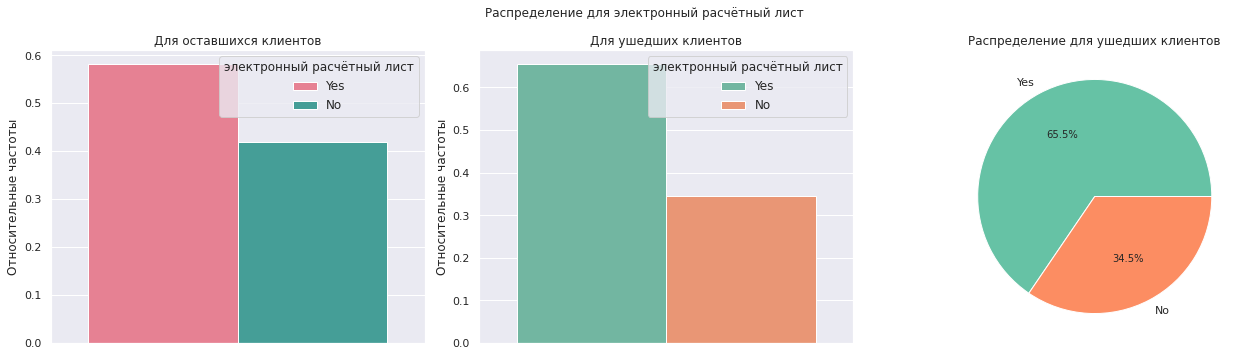

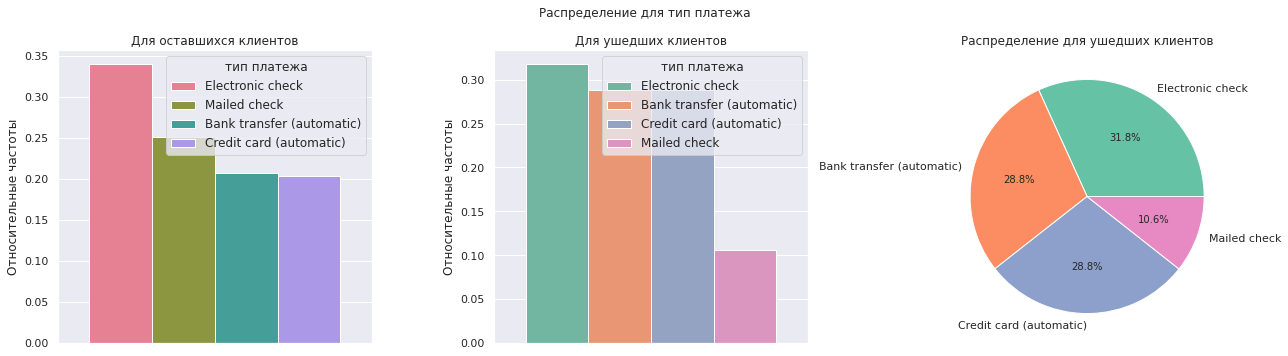

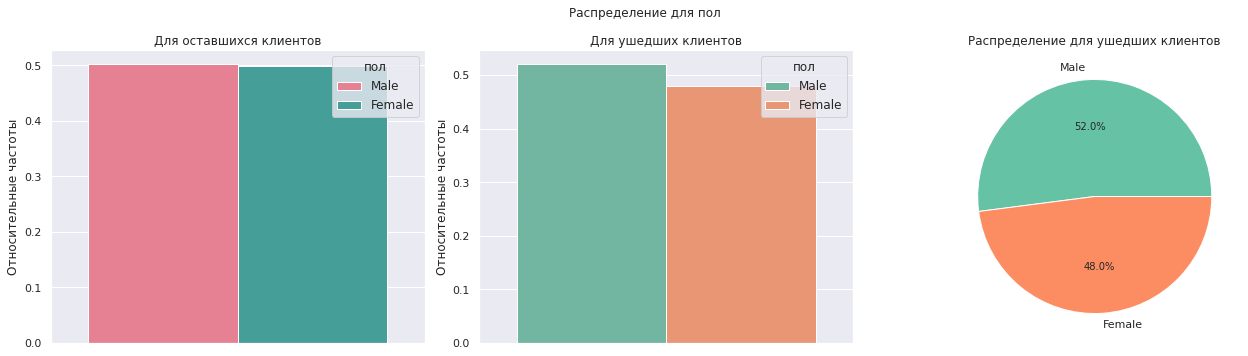

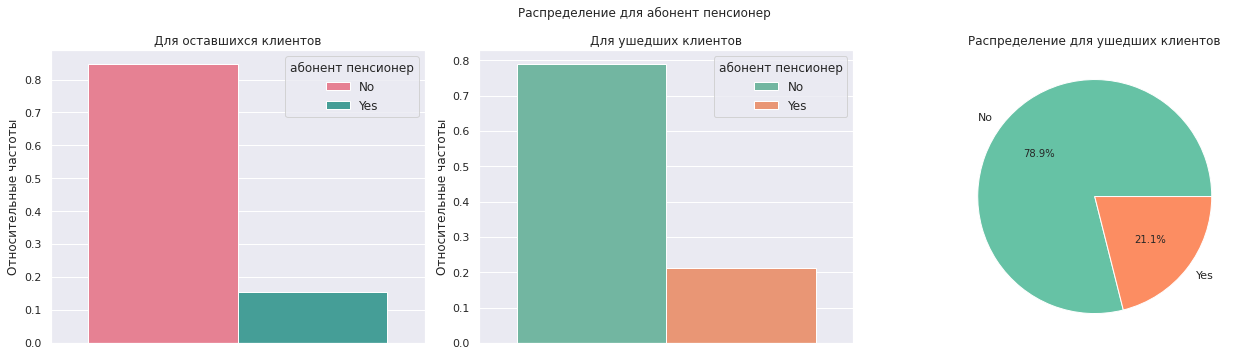

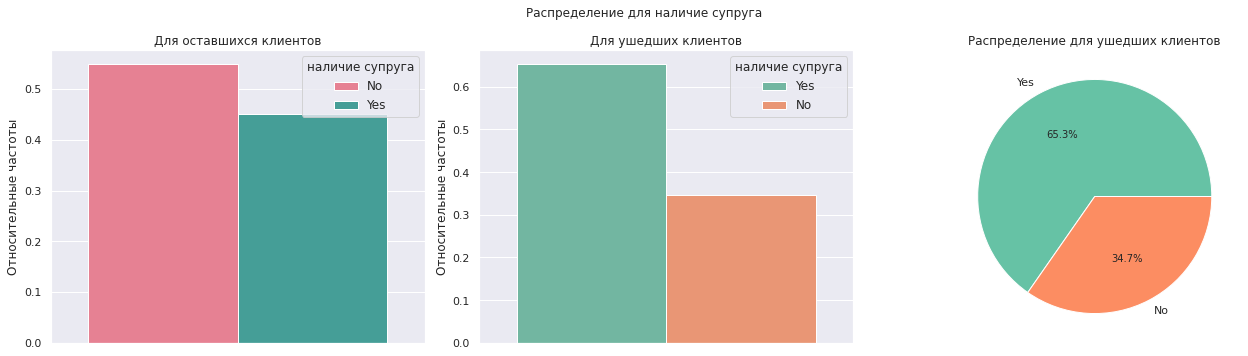

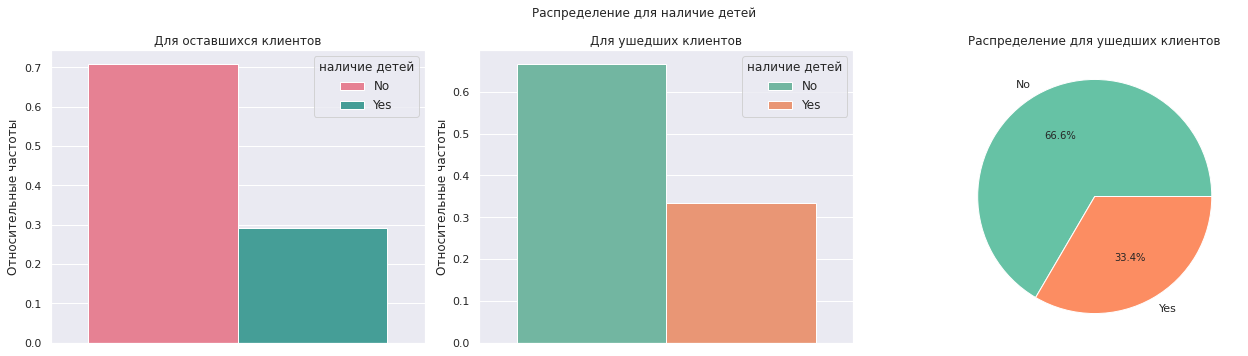

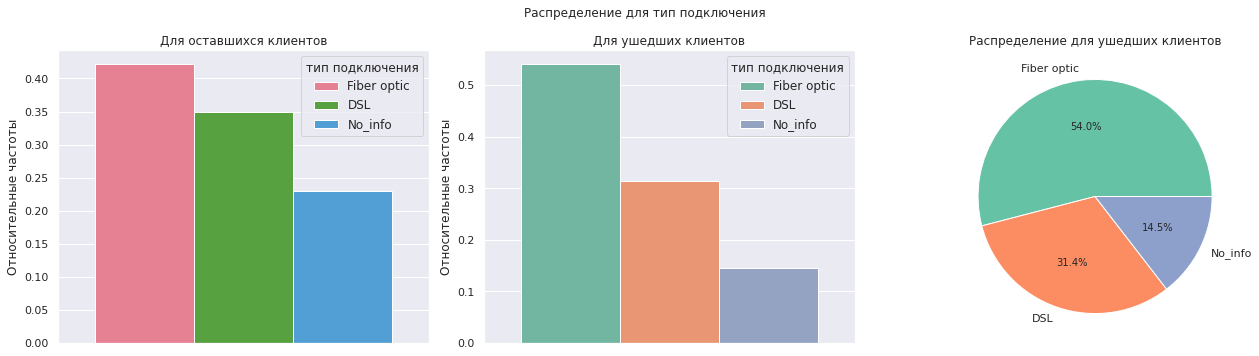

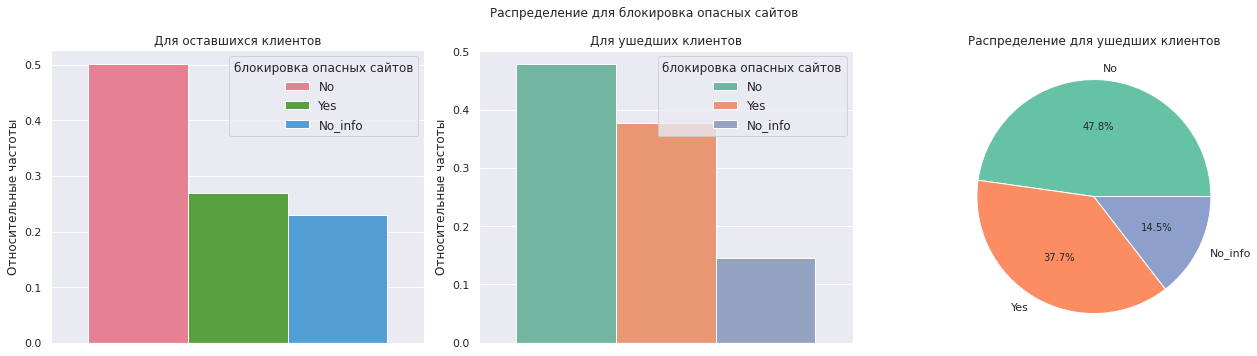

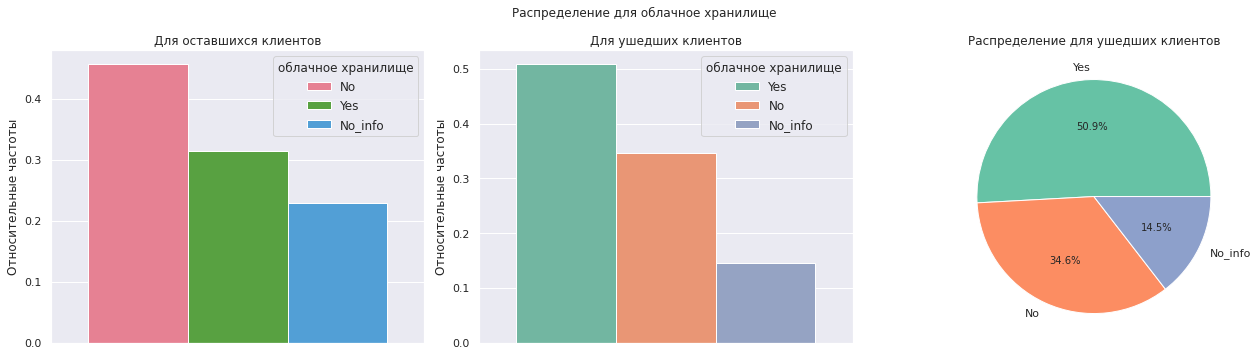

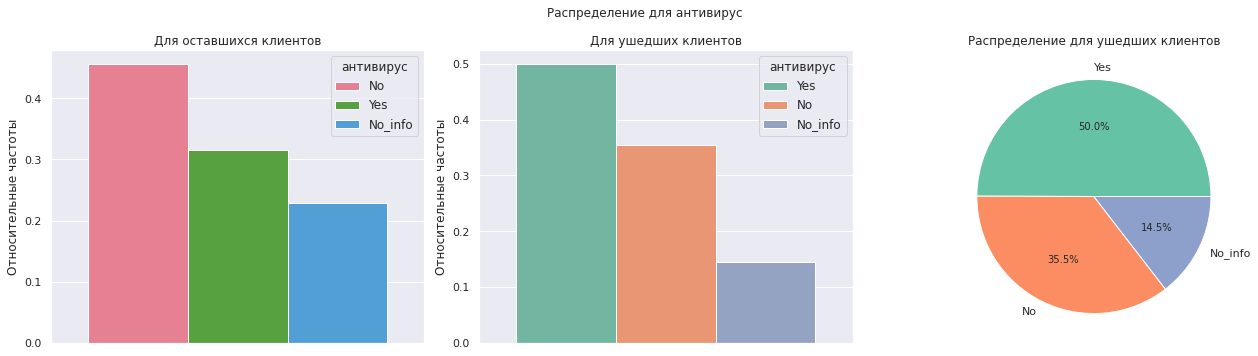

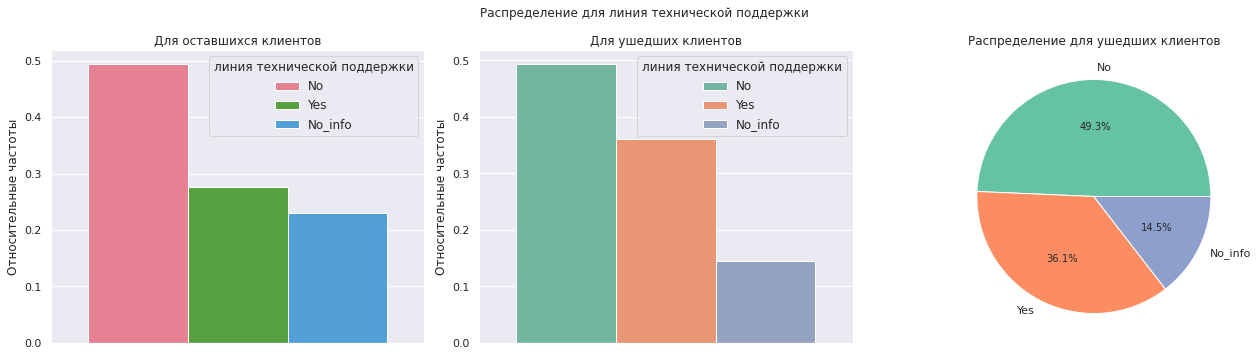

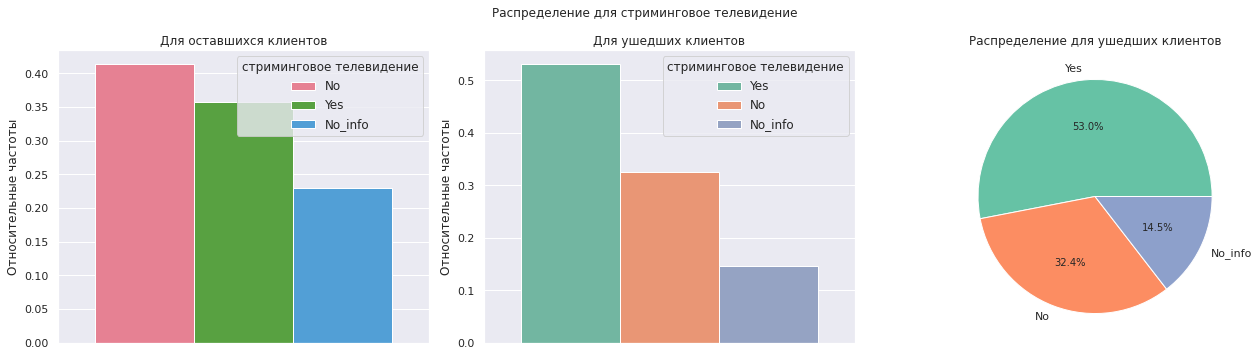

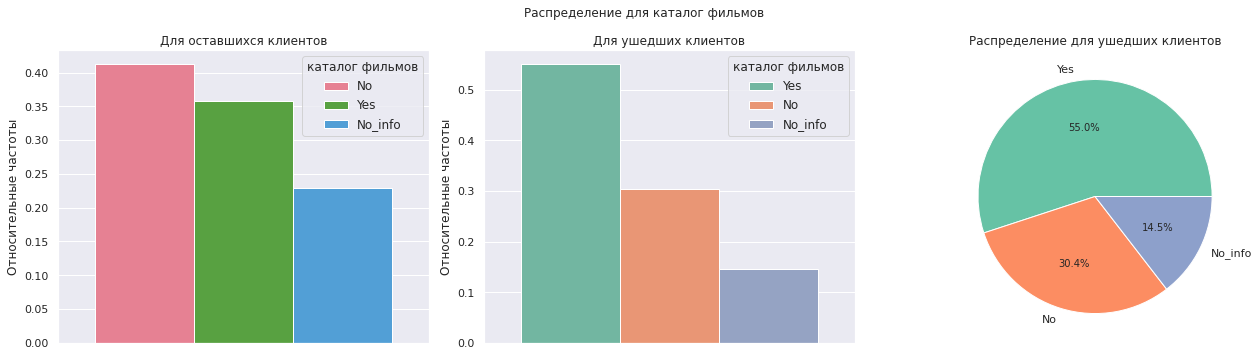

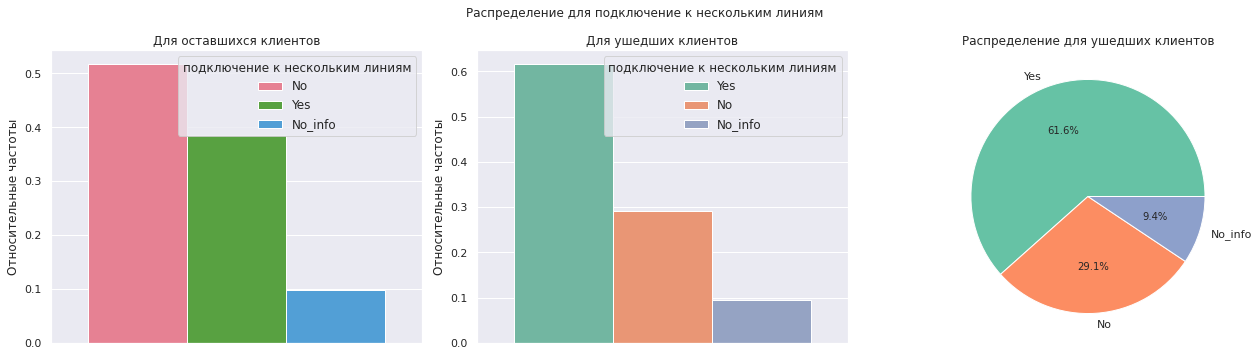

In [59]:
categorial_plot_quit(df, 'Составление портрета ушедшего клиента', categories)

1. Тип оплаты: Клиенты с ежемесячной оплатой (Month-to-month) чаще покидают, в отличие от тех, кто заключил контракт на год или два.
2. Электронный расчетный лист: Клиенты, использующие электронный расчетный лист, с большей вероятностью расторгают договор.
3. Тип платежа: Клиенты, использующие электронные чеки (Electronic check), чаще расторгают договор по сравнению с другими методами оплаты.
4. Пол: Пол клиентов (мужской или женский) не является значительным фактором для ухода, распределение примерно равное.
5. Абонент пенсионер: не пенсионеры чаще покидают компанию по сравнению с остальными группами населения.
6. Наличие супруга: Клиенты с супругом имеют более высокую вероятность расторжения договора.
7. Наличие детей: Клиенты без детей более склонны к расторжению договора.
8. Тип подключения: Клиенты с оптоволоконным соединением (Fiber optic) чаще расторгают договора по сравнению с другими типами подключения.
9. Блокировка опасных сайтов: Клиенты без информации о блокировке или без блокировки опасных сайтов чаще расторгают договор.
10. Облачное хранилище: Клиенты с облачным хранением чаще расторгают договор, чем те, у кого нет этой услуги.
11. Антивирус: Клиенты с антивирусом имеют большую вероятность ухода.
12. Линия технической поддержки: Клиенты без доступа к линии технической поддержки чаще расторгают договор.
13. Стриминговое телевидение: Клиенты со стриминговым телевидением чаще уходят.
14. Каталог фильмов: Клиенты с доступом к каталогу фильмов имеют более высокий уровень оттока.
15. Подключение к нескольким линиям: Клиенты с возможностью подключения к нескольким линиям реже покидают компанию, чем те, у кого нет этой возможности.

In [60]:
def numerical_plot_quit(df: pd.DataFrame, title: str, features: dict, sign: str or list = 'target'):
    '''
    function for plotting numerical distribution
    params: df: dataframe for research
            tltle: name for plot title
            features: dict of features to research, keys - eng, values - ru for captions
    '''
    print(f'Графики количественных признаков для {title}')

    for feature, feat_ru in features.items():
        fig, axes = plt.subplots(1, 2, figsize=(18, 5))
        if df[feature].dtype == 'int64' and len(df[feature].unique()) < 20:

            data_no = df[df[sign] == "No"][feature].value_counts(normalize=True).reset_index()
            data_yes = df[df[sign] == "Yes"][feature].value_counts(normalize=True).reset_index()
            sns.barplot(data=data_yes, y='proportion', x=feature, ax=axes[0], color='#FC8D62', alpha=0.75, label='Yes')
            sns.barplot(data=data_no, y='proportion', x=feature, ax=axes[0], color='#66C2A5', label='No', fill=False)

        else:
            sns.histplot(data=df,
                         x=feature,
                         kde=True,
                         ax=axes[0],
                         bins=round(log((len(df[feature].unique()) + 1)) * 2, ),
                         hue=sign,
                         stat='density',
                         common_norm=False)
        sns.boxplot(data=df, x=feature, ax=axes[1], hue=sign)
        fig.suptitle(f'Распределение для {feat_ru}')
        for num in range(2):
            axes[num].set_ylabel('Проценты')
            axes[num].set_xlabel(feat_ru)

### Анализ количественных признаков в зависимости от того, ушел пользователь или нет

In [61]:
numeric = {'monthly_charges': 'расходы за месяц',
           'total_charges': 'общие расходы абонента',
           'duration': 'длительность контракта'}

Графики количественных признаков для Составление портрета ушедшего потребителя


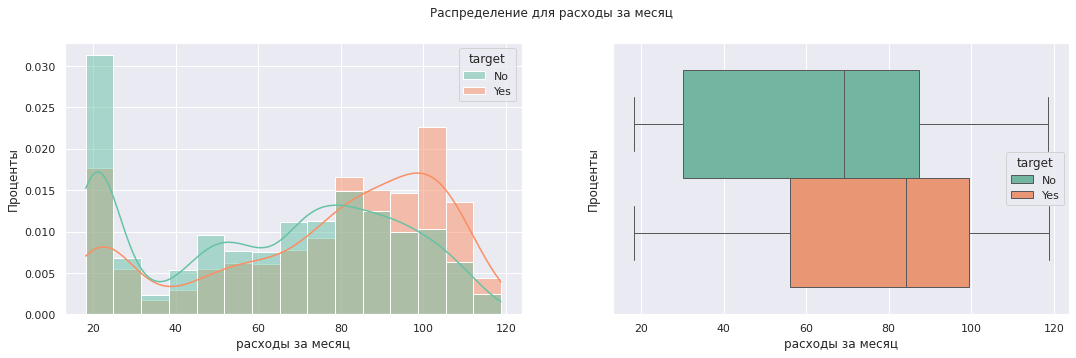

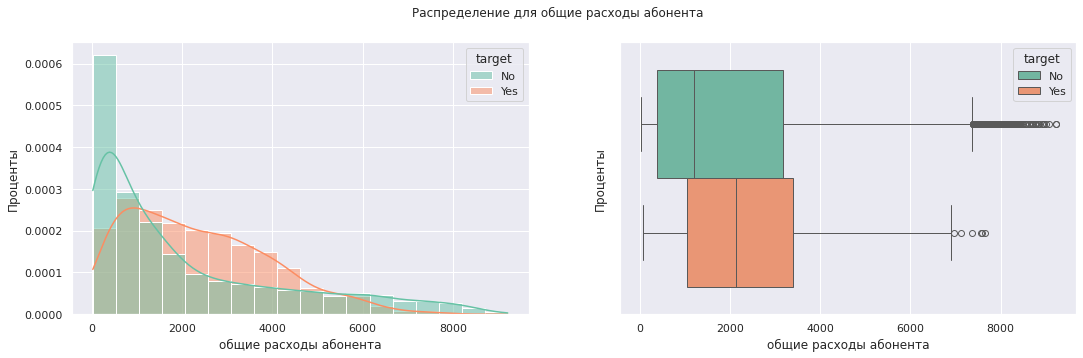

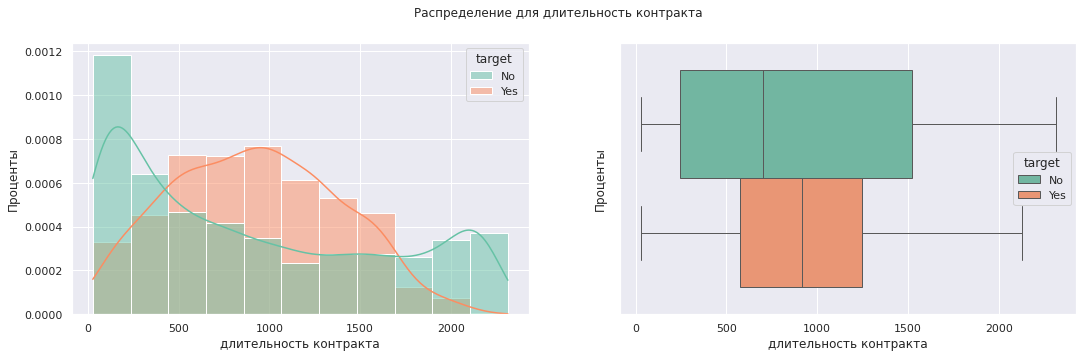

In [62]:
numerical_plot_quit(df, 'Составление портрета ушедшего потребителя', numeric)

1. Расходы за месяц: Клиенты с более высокими месячными расходами имеют больше шансов покинуть.
2. Общие расходы абонента: Высокие общие расходы абонентов связаны с более высокой вероятностью ухода.
3. Длительность контракта: Клиенты со средней длительностью контракта чаще покидают компанию.

**Ttest для `monthly_charges`**

Сформулируем гипотезу, которую мы хотим проверить:

$H_0$: Средние двух выборок: ушедшие клиенты и неушедшие клиенты равны для параметра `monthly_charges`

$H_1$: Средние двух выборок не равны

In [63]:
results = ttest_ind(df.query('target == "Yes"')['monthly_charges'],
                    df.query('target == "No"')['monthly_charges'])

print(f'p-value: {results.pvalue}')

alpha = 0.05

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-value: 1.526961409599664e-38
Отвергаем нулевую гипотезу


На основании проведённого t-теста для проверки гипотезы о равенстве средних значений ежемесячных расходов (monthly_charges) между ушедшими и неушедшими клиентами:

Результаты t-теста:
- p-value: \(1.5269614095996638e-38\) (практически 0).

Заключение:
- $p \text{-value}$ значительно меньше уровня значимости $alpha = 0.05$, поэтому мы отвергаем нулевую гипотезу.

Следовательно, имеются статистически значимые различия в средних значениях ежемесячных расходов между ушедшими и неушедшими клиентами.

**Ttest для `total_charges`**

Сформулируем гипотезу, которую мы хотим проверить:

$H_0$: Средние двух выборок: ушедшие клиенты и неушедшие клиенты равны для параметра `total_charges`

$H_1$: Средние двух выборок не равны

In [64]:
results = ttest_ind(df.query('target == "Yes"')['total_charges'],
                    df.query('target == "No"')['total_charges'])

print(f'p-value: {results.pvalue}')

alpha = 0.05

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-value: 1.5266437242636794e-05
Отвергаем нулевую гипотезу


На основании проведённого t-теста для проверки гипотезы о равенстве средних значений общих расходов `total_charges` между ушедшими и неушедшими клиентами:

Результаты t-теста:
- p-value: \(1.526437242636794e-05\).

Заключение:
- $p \text{-value}$ значительно меньше уровня значимости $(alpha = 0.05)$, поэтому мы отвергаем нулевую гипотезу.

Следовательно, имеются статистически значимые различия в средних значениях общих расходов между ушедшими и неушедшими клиентами.

**Ttest для `duration`**

Сформулируем гипотезу, которую мы хотим проверить:

$H_0$: Средние двух выборок: ушедшие клиенты и неушедшие клиенты равны для параметра `duration`

$H_1$: Средние двух выборок не равны

In [65]:
results = ttest_ind(df.query('target == "Yes"')['monthly_charges'],
                    df.query('target == "No"')['monthly_charges'])

print(f'p-value: {results.pvalue}')

alpha = 0.05

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-value: 1.526961409599664e-38
Отвергаем нулевую гипотезу


На основании проведённого t-теста для проверки гипотезы о равенстве средних значений общих расходов `total_charges` между ушедшими и неушедшими клиентами:

Результаты t-теста:
- p-value: \(1.5269614095996638e-38\).

Заключение:
- $p \text{-value}$ значительно меньше уровня значимости $(alpha = 0.05)$, поэтому мы отвергаем нулевую гипотезу.

Следовательно, имеются статистически значимые различия в средних значениях общих расходов между ушедшими и неушедшими клиентами.

Рассмотрим также распределение целевой переменой для объединенного датафрейма

Графики категориальных признаков для Распределение целевой переменной в объединенном датафрейме


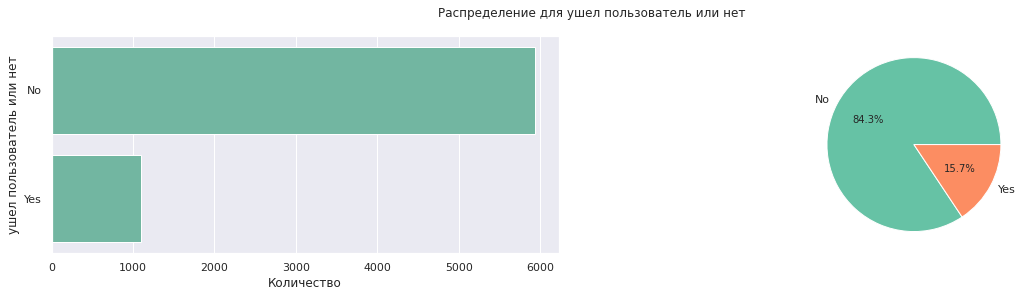

In [66]:
categorial_plot(df, 'Распределение целевой переменной в объединенном датафрейме', {'target': 'ушел пользователь или нет'})

Отметим, что данные несбалансированны. Для дальнейшего обучения моделей не будем делать даунсайз или андерсемплинг, а будем настраивать модель

**Вывод по исследовательскому анализу объединенного датафрейма**:

1. Матрицы корреляций:
- Первая матрица: Корреляция Спирмена для количественных признаков:
   - total_charges и duration: Очень высокая положительная корреляция, что логично, так как общие расходы суммируются с течением времени.
   - monthly_charges и total_charges: Умеренная положительная корреляция, так как более высокие месячные расходы увеличивают общие расходы.

- Вторая матрица: Корреляция с использованием phi-корреляции для всех признаков:
   - Целевая переменная (target):
     - Слабая положительная корреляция с payment_method, monthly_charges, total_charges, partner.
     - Умеренная положительная корреляция с duration.
   - monthly_charges:
     - Высокая положительная корреляция с total_charges, internet_service, streaming_tv, streaming_movies, multiple_lines, device_protection, tech_support, online_backup, online_security.
     - Умеренная положительная корреляция с paperless_billing.
   - Уход клиента (target): Значимые корреляции с duration (длительность контракта), monthly_charges, payment_method, partner, total_charges.
   
2. Основные категории причин ухода (target):
   - Клиенты с ежемесячной оплатой и электронными расчетными листами чаще покидают.
   - Не пенсионеры, клиенты с супругом или без детей чаще уходят.
   - Оптоволоконное соединение, отсутствие информации о блокировке сайтов, облачное хранение, отсутствие техподдержки, стриминговое ТВ и каталог фильмов увеличивают вероятность ухода.
   - Клиенты с несколькими линиями реже покидают компанию.

3. t-тест для monthly_charges, total_charges, duration показал, что отвергнута теория что средние значения для ушедших и не ушедших клиентов статистически не различаются.

4. Анализ распределения таргета выявил наличие дисбаланса.

Графики:

1. Количественные признаки:
   - Высокие месячные расходы и общие расходы коррелируют с уходом.
   - Клиенты с короткими контрактами и высокими расходами склонны к уходу.

2. Категориальные признаки:
   - Определенные типы оплаты и услуг, наличие супруга и отсутствие детей связаны с большим риском ухода.

Эти данные подчеркивают важность факторов, таких как тип оплаты, услуги для анализа и предотвращения ухода клиентов.

## **Шаг 5. Подготовка данных**

In [67]:
X = df.drop(columns='target')
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    stratify=y,
    random_state=RANDOM_STATE
)

In [68]:
del contract_new
del internet_new
del personal_new
del phone_new
gc.collect()

129518

Данные разделены на обучающую и тестовую выборку и готовы для обучения

## **Шаг 6. Обучение моделей машинного обучения**

В качестве моделей будем использовать ансамбль дерева решений (RandomForestClassifier) и градиентные методы: Gradient Boosting on Decision Trees (GBDT) и Light Gradient Boosted Machine (LightGBM)

In [69]:
num_cols = ['monthly_charges', 'total_charges', 'duration']
cat_cols = ['type', 'paperless_billing', 'payment_method', 'gender', 'senior_citizen', 'partner', 'dependents', 
            'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 
            'streaming_tv', 'streaming_movies', 'multiple_lines']

preprocessor_ohe = ColumnTransformer([
    ('num_processing', StandardScaler(), num_cols),
    ('cat_processing', OneHotEncoder(handle_unknown='ignore', drop='first'), cat_cols)
], remainder='passthrough')

pipe_final = Pipeline([
    ('preprocessor', preprocessor_ohe),
    ('model', LGBMClassifier(random_state=RANDOM_STATE))
])

params_grid = [
    {
        'model': [LGBMClassifier(random_state=RANDOM_STATE)],
        'model__n_estimators': range(500, 900, 100),
        'model__learning_rate': [0.1, 0.01, 0.001],
        'model__max_depth': [-1, 7, 10],
        'preprocessor__num_processing': [RobustScaler(), MinMaxScaler()]
    },
    {
        'model': [RandomForestClassifier(random_state=RANDOM_STATE)],
        'model__n_estimators': [100, 200, 300],
        'model__max_depth': [None, 10, 20, 30],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4],
    },
    {
        'model': [GradientBoostingClassifier(random_state=RANDOM_STATE)],
        'model__n_estimators': [100, 200, 300],
        'model__learning_rate': [0.1, 0.01, 0.001],
        'model__max_depth': [3, 7, 10],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4],
    }
]

label_encoder = LabelEncoder()
y_train_encoder = label_encoder.fit_transform(y_train)
y_test_encoder = label_encoder.transform(y_test)

In [70]:
grid_search = RandomizedSearchCV(estimator=pipe_final, 
                                 param_distributions=params_grid,
                                 n_iter=50, 
                                 cv=5, 
                                 verbose=2, 
                                 random_state=RANDOM_STATE, 
                                 n_jobs=-1,
                                 scoring='roc_auc')
grid_search.fit(X_train, y_train_encoder)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END model=GradientBoostingClassifier(random_state=20924), model__learning_rate=0.1, model__max_depth=10, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=200; total time=   4.6s
[CV] END model=GradientBoostingClassifier(random_state=20924), model__learning_rate=0.1, model__max_depth=10, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=200; total time=   4.6s
[CV] END model=GradientBoostingClassifier(random_state=20924), model__learning_rate=0.1, model__max_depth=10, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=200; total time=   4.6s
[CV] END model=GradientBoostingClassifier(random_state=20924), model__learning_rate=0.1, model__max_depth=10, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=200; total time=   4.6s
[CV] END model=GradientBoostingClassifier(random_state=20924), model__learning_rate=0.1, model__ma

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('num_processing',
                                                                               StandardScaler(),
                                                                               ['monthly_charges',
                                                                                'total_charges',
                                                                                'duration']),
                                                                              ('cat_processing',
                                                                               OneHotEncoder(drop='first',
                                                                                             handle_unknown='ignore'),
                                                                               ['type',
                                                                                'paperless_billing',
                                                                                'payment_method',
                                                                                'gender',
                                                                                'senior_citizen',
                                                                                'par...
                                         'model__min_samples_split': [2, 5, 10],
                                         'model__n_estimators': [100, 200,
                                                                 300]},
                                        {'model': [GradientBoostingClassifier(random_state=20924)],
                                         'model__learning_rate': [0.1, 0.01,
                                                                  0.001],
                                         'model__max_depth': [3, 7, 10],
                                         'model__min_samples_leaf': [1, 2, 4],
                                         'model__min_samples_split': [2, 5, 10],
                                         'model__n_estimators': [100, 200,
                                                                 300]}],
                   random_state=20924, scoring='roc_auc', verbose=2)

In [71]:
best_decision = grid_search.best_estimator_
best_model = best_decision.named_steps['model']

In [72]:
pd.DataFrame(grid_search.cv_results_).sort_values(by='rank_test_score', ascending=True).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__n_estimators,param_model__min_samples_split,param_model__min_samples_leaf,param_model__max_depth,param_model__learning_rate,param_model,param_preprocessor__num_processing,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
16,2.108193,0.021649,0.017228,0.000097,300,2,4,3,0.1,GradientBoostingClassifier(random_state=20924),NaN,"{'model__n_estimators': 300, 'model__min_sampl...",0.870463,0.899026,0.876364,0.895164,0.862740,0.880751,0.014080,1
20,4.866353,0.146576,0.100165,0.052770,600,NaN,NaN,7,0.1,LGBMClassifier(random_state=20924),RobustScaler(),{'preprocessor__num_processing': RobustScaler(...,0.871699,0.873905,0.875853,0.891336,0.875686,0.877696,0.006983,2
29,7.197717,0.211654,0.117847,0.034777,800,NaN,NaN,10,0.1,LGBMClassifier(random_state=20924),MinMaxScaler(),{'preprocessor__num_processing': MinMaxScaler(...,0.873109,0.871651,0.868396,0.886586,0.881774,0.876303,0.006783,3
26,5.635284,0.135584,0.097371,0.000920,600,NaN,NaN,10,0.1,LGBMClassifier(random_state=20924),MinMaxScaler(),{'preprocessor__num_processing': MinMaxScaler(...,0.871004,0.870589,0.868567,0.887135,0.880547,0.875568,0.007116,4
6,5.454155,0.122508,0.104996,0.074065,700,NaN,NaN,7,0.1,LGBMClassifier(random_state=20924),MinMaxScaler(),{'preprocessor__num_processing': MinMaxScaler(...,0.872700,0.873742,0.876643,0.883279,0.866489,0.874571,0.005470,5


In [73]:
print('Лучшая модель и её параметры:\n\n', best_decision)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_processing',
                                                  StandardScaler(),
                                                  ['monthly_charges',
                                                   'total_charges',
                                                   'duration']),
                                                 ('cat_processing',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['type', 'paperless_billing',
                                                   'payment_method', 'gender',
                                                   'senior_citizen', 'partner',
                                                   'dependent

In [74]:
print(f'Метрика ROC-AUC лучшей модели по кросс-валидации на обучающих данных: {round(grid_search.best_score_, 4)}')

Метрика ROC-AUC лучшей модели по кросс-валидации на обучающих данных: 0.8808


**Вывод:**
- Был сформирован пайплайн с предобработкой пропусков, а также нормализации количественных признаков и кодирования категориальных переменных
- Таргетный признак был закодирован с помощью LabelEncoder
- Были перебраны гиперпараметры для трех моделей: GradientBoostingClassifier, RandomForestClassifier, LGBMClassifier
- При помощи RandomizedSearchCV были обучены модели и лучшая метрика на кроссвалидации была у модели  GradientBoostingClassifier(min_samples_leaf=4, n_estimators=300, random_state=20924) - 0.8831
- Поскольку требуемая точность >= 0.85, было принято решение представить эту модель как финальную и протестировать ее на тестовой выборке

## **Шаг 7. Выбор лучшей модели**

In [75]:
best_model = grid_search.best_estimator_
test_preds_proba = best_model.predict_proba(X_test)[:, 1]
test_preds = best_model.predict(X_test)

test_auc = roc_auc_score(y_test_encoder, test_preds_proba)
test_accuracy = accuracy_score(y_test_encoder, test_preds)

print(f"Результат лучшей модели на тестовом наборе (AUC-ROC): {round(test_auc, 4)}")
print(f"Результат лучшей модели на тестовом наборе (Accuracy): {round(test_accuracy, 4)}")

Результат лучшей модели на тестовом наборе (AUC-ROC): 0.8942
Результат лучшей модели на тестовом наборе (Accuracy): 0.8896


Необходимую точность метрика (AUC-ROC) показывает на тестовом наборе данных: 0.8942

Проведем анализ важности признаков для модели

In [76]:
x_Train = pd.DataFrame(best_decision['preprocessor'].fit_transform(X_train),
                      columns=best_decision.named_steps['preprocessor'].get_feature_names_out())
x_Test = pd.DataFrame(best_decision['preprocessor'].transform(X_test),
                     columns=best_decision.named_steps['preprocessor'].get_feature_names_out())

In [77]:
explainer = shap.KernelExplainer(best_decision['model'].predict_proba, x_Train[:10])

shap_values = explainer.shap_values(x_Test[:100])[:, :, 0]
shap.force_plot(explainer.expected_value[0], shap_values, x_Test)

  0%|          | 0/100 [00:00<?, ?it/s]

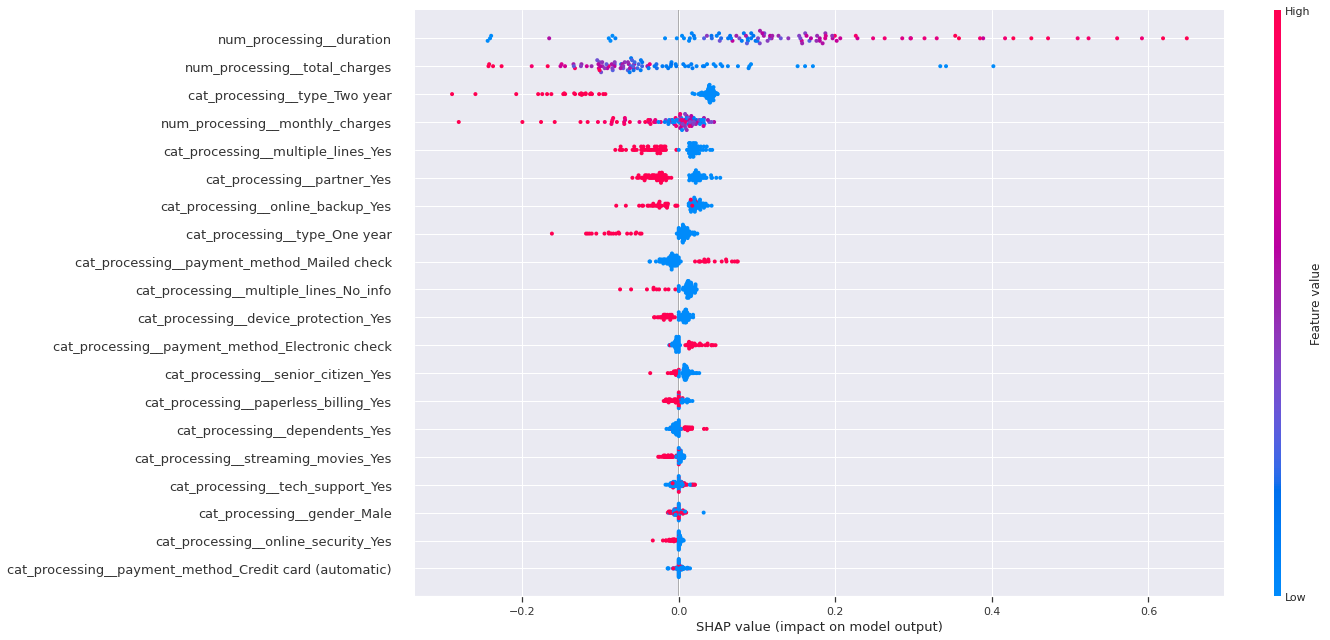

In [78]:
shap.summary_plot(shap_values, x_Test[:100], plot_size=(20,9))

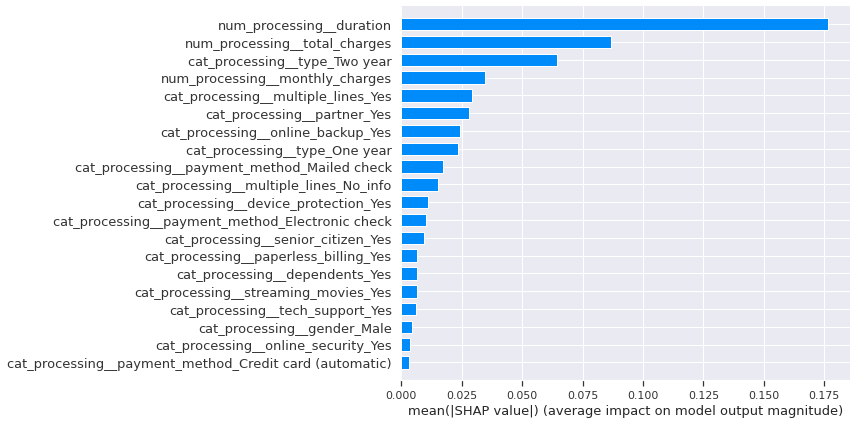

In [79]:
shap.summary_plot(shap_values, x_Test[:100], plot_type="bar", plot_size=(12, 6))

Стоит отметить, что наибольшее значение для модели является длительность контракта, общие затраты клиента, тип платежа (ежемесячно), ежемесячные затраты и тип платежа (раз в два года)

**Вывод:**
- Была достигнута необходимая метрика (AUC-ROC) на тестовом наборе данных: 0.9017
- Результат лучшей модели на тестовом наборе по дополнительной метрике (Accuracy): 0.894
- Были построены графики для интерпретации решения модели: наибольшее значение для модели является длительность контракта, общие затраты клиента, тип платежа (ежемесячно), ежемесячные затраты и тип платежа (раз в два года)

## **Шаг 8. Общий вывод и рекомендации заказчику**

### Общий вывод по проекту:
**Вывод по загрузке данных:**
- Данные были успешно прочитаны и преобразованы в датафрейм
- Датафреймы представляют собой данные о пользователях, предоставляемых им услугах, оплаты тарифов
- Представлены датафреймы разной длины - 7043, 6361 и 5517 строк. В каждом датафрейме определенное количество признаков, которые необходимо привести к нижнему регистру для удобства работы.

**Вывод по исследовательскому анализу данных**

**contract_new**
- Признаки:
  - В датафрейме 8 признаков, один из которых — уникальный идентификатор пользователя.
  - Дата конца контракта была преобразована в таргетную переменную, а разница между началом и концом контракта была преобразована в новый признак — длительность.

- Количественные признаки:
  - Изначально было 2 количественных признака: monthly_charges и total_charges.
  - Для признака total_charges было удалено малое количество пропусков, мешавших преобразованию столбца.
  - Новый созданный признак — длительность контракта — также можно включить в количественные признаки.
      
- Графическое представление monthly_charges и total_charges:
  - Расходы за месяц (monthly_charges):
    - Гистограмма показывает, что большинство значений находятся в диапазоне от 20 до 40, но значительное количество значений также расположено в диапазоне от 80 до 120.
    - Boxplot показывает распределение значений, медиану, квартали и предполагает наличие выбросов.
  - Общие расходы абонента (total_charges):
    - Гистограмма показывает асимметрическое распределение с большим количеством значений в низком диапазоне.
    - Boxplot подтверждает наличие выбросов на верхнем уровне.

- Категориальные признаки:
  - В датафрейме 3 категориальных признака: type, paperless_billing, payment_method.
  - paperless_billing является бинарным признаком.

**internet_new**

- В датафрейме 8 признаков, один из которых — уникальный идентификатор пользователя.
- Остальные признаки — категориальные бинарные признаки.
- Наименьший по количеству строк — 5517 строк.

**personal_new**
- В датафрейме 5 признаков, один из которых — уникальный идентификатор пользователя.
- Остальные признаки — категориальные бинарные признаки.
- Для признака senior_citizen было выполнено преобразование значений из {0, 1} в {'Yes', 'No'}.
- Количество строк — 7043.

**phone_new**
- В датафрейме 2 признака, один из которых — уникальный идентификатор пользователя.
- Второй признак — категориальный бинарный признак наличия подключения к нескольким линиям одновременно.
- Количество строк — 6361.

**Вывод по исследовательскому анализу объединенного датафрейма**:

1. Матрицы корреляций:
- Первая матрица: Корреляция Спирмена для количественных признаков:
   - total_charges и duration: Очень высокая положительная корреляция, что логично, так как общие расходы суммируются с течением времени.
   - monthly_charges и total_charges: Умеренная положительная корреляция, так как более высокие месячные расходы увеличивают общие расходы.

- Вторая матрица: Корреляция с использованием phi-корреляции для всех признаков:
   - Целевая переменная (target):
     - Слабая положительная корреляция с payment_method, monthly_charges, total_charges, partner.
     - Умеренная положительная корреляция с duration.
   - monthly_charges:
     - Высокая положительная корреляция с total_charges, internet_service, streaming_tv, streaming_movies, multiple_lines, device_protection, tech_support, online_backup, online_security.
     - Умеренная положительная корреляция с paperless_billing.
   - Уход клиента (target): Значимые корреляции с duration (длительность контракта), monthly_charges, payment_method, partner, total_charges.
   
2. Основные категории причин ухода (target):
   - Клиенты с ежемесячной оплатой и электронными расчетными листами чаще покидают.
   - Не пенсионеры, клиенты с супругом или без детей чаще уходят.
   - Оптоволоконное соединение, отсутствие информации о блокировке сайтов, облачное хранение, отсутствие техподдержки, стриминговое ТВ и каталог фильмов увеличивают вероятность ухода.
   - Клиенты с несколькими линиями реже покидают компанию.

3. t-тест для monthly_charges, total_charges, duration показал, что отвергнута теория что средние значения для ушедших и не ушедших клиентов статистически не различаются.

4. Анализ распределения таргета выявил наличие дисбаланса.

Графики:

1. Количественные признаки:
   - Высокие месячные расходы и общие расходы коррелируют с уходом.
   - Клиенты с короткими контрактами и высокими расходами склонны к уходу.

2. Категориальные признаки:
   - Определенные типы оплаты и услуг, наличие супруга и отсутствие детей связаны с большим риском ухода.

Эти данные подчеркивают важность факторов, таких как тип оплаты, услуги для анализа и предотвращения ухода клиентов.

Датафрейм contract_new содержит важные количественные и категориальные признаки, которые могут предоставить ценные инсайты для анализа. Анализ распределений признаков monthly_charges и total_charges показал разнообразие значений, а также наличие выбросов, что может быть полезным для дальнейшего статистического и машинного анализа данных. Остальные таблицы (internet_new, personal_new, phone_new) состоят в основном из бинарных категориальных признаков и отличаются лишь количеством строк.

**Вывод по объединению датафрейма:**
- Все 4 датафрейма были объединены между собой по идентификатору пользователя.
- Поскольку данные были объедены относительно `contract_new` (информация о договоре), были заполнены пропуски при помощи заглушки

**Обучение модели:**
- Данные были разделены на тестовую и тренировочную выборку с учетом таргетной переменной
- Был сформирован пайплайн с предобработкой пропусков, а также нормализации количественных признаков и кодирования категориальных переменных
- Таргетный признак был закодирован с помощью LabelEncoder
- Были перебраны гиперпараметры для трех моделей: GradientBoostingClassifier, RandomForestClassifier, LGBMClassifier
- При помощи RandomizedSearchCV были обучены модели и лучшая метрика на кроссвалидации была у модели  GradientBoostingClassifier(min_samples_leaf=4, n_estimators=300, random_state=20924) - 0.8831
- Поскольку требуемая точность >= 0.85, было принято решение представить эту модель как финальную и протестировать ее на тестовой выборке

**Финальный анализ модели:**
- Была достигнута необходимая метрика (AUC-ROC) на тестовом наборе данных: 0.9016
- Результат лучшей модели на тестовом наборе по дополнительной метрике (Accuracy): 0.894
- Были построены графики для интерпретации решения модели: наибольшее значение для модели является длительность контракта, общие затраты клиента, тип платежа (ежемесячно), ежемесячные затраты и тип платежа (раз в два года)


**Рекомендации заказчику**:
- Для предложения более выгодной цены и скидок пользователям стоит обратить на данные группы клиентов: 
   - Определенные типы оплаты (Month-to-Month) и услуг(подключение телефона к нескольким линиям одновременно, облачного хранилища файлов для резервного копирования данных)
   - Высокие месячные расходы и общие расходы коррелируют с уходом